In [1]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#fix_pythonpath_if_working_locally()

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)

from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)


import logging
logging.disable(logging.CRITICAL)

import warnings
warnings.filterwarnings("ignore")

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

##### READ THE DATA

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# read dataset and make a table
data = pd.read_csv('../dataset/MonthlyMilkIncompleteDataset.csv', header=0)#, parse_dates=["Month"])
print(data.info())
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Month           168 non-null    object 
 1   Pounds per cow  155 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.8+ KB
None


,Month,Pounds per cow
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0
...,...,...
163,1975-08-01,858.0
164,1975-09-01,NaN
165,1975-10-01,NaN
166,1975-11-01,797.0


##### VISUALIZE IMPORTED DATA

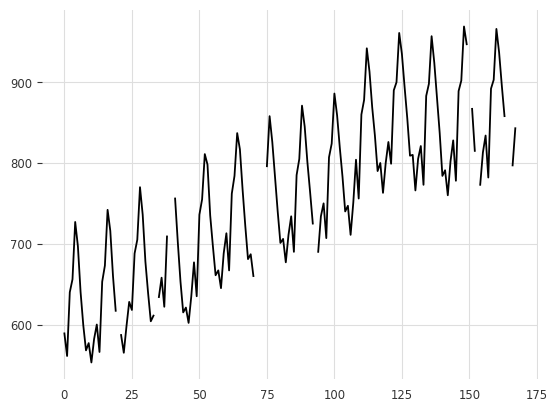

In [3]:
plt.plot(data['Pounds per cow'])
plt.show()

##### CONVERT PANDAS DATAFRAME TO DARTS TIMESERIES

In [4]:
import darts
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(
    data,
    time_col="Month",
    value_cols="Pounds per cow",
    fill_missing_dates=True,
    freq="MS",  # "M" stands for monthly
)

#series = fill_missing_values(series=series, fill='auto')

series

<TimeSeries (DataArray) (Month: 168, component: 1, sample: 1)>
array([[[589.]],

       [[561.]],

       [[640.]],

       [[656.]],

       [[727.]],

       [[697.]],

       [[640.]],

       [[599.]],

       [[568.]],

       [[577.]],

...

       [[892.]],

       [[903.]],

       [[966.]],

       [[937.]],

       [[896.]],

       [[858.]],

       [[ nan]],

       [[ nan]],

       [[797.]],

       [[843.]]])
Coordinates:
  * Month      (Month) datetime64[ns] 1962-01-01 1962-02-01 ... 1975-12-01
  * component  (component) object 'Pounds per cow'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

##### FILL EMPTY ROWS WITH MISSING DATA

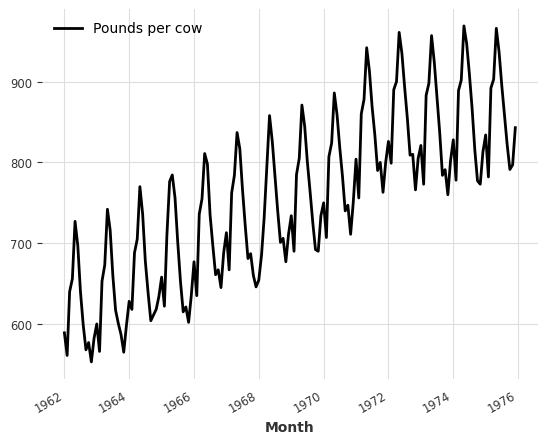

In [5]:
filler = MissingValuesFiller()
series = filler.transform(series, method="quadratic")

series.plot()

##### PREPROCESSING
Generally, many machine learning algorithms tend to work better on data preprocessed (normalisation/standardization). This block of code will create a MixMax Scaler to normalise these time series to values between 0 and 1

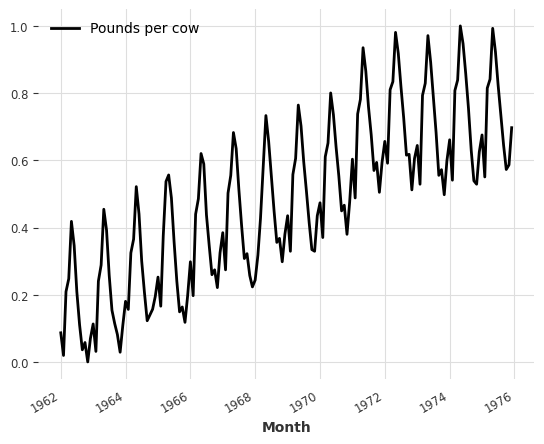

In [6]:
scaler = Scaler()
series = scaler.fit_transform(series)

series["Pounds per cow"].plot(label="Pounds per cow")
plt.legend();

##### DATA SEPARATION

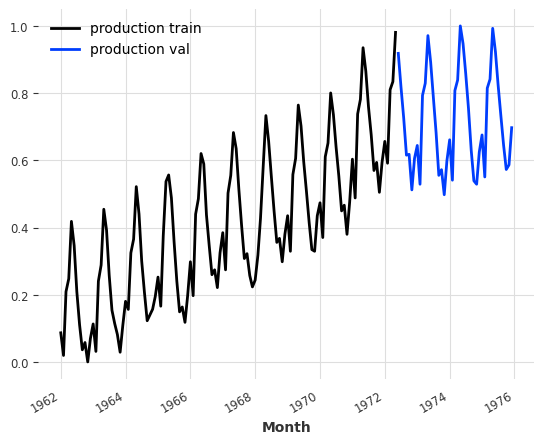

In [7]:
# Split Dataset into Training and Validation sets
train, val = series.split_before(0.75)
#train, val = series.split_before(pd.Timestamp("1973-01-01"))


train['Pounds per cow'].plot(label='production train')
val['Pounds per cow'].plot(label='production val');

##### MODEL TRAINING

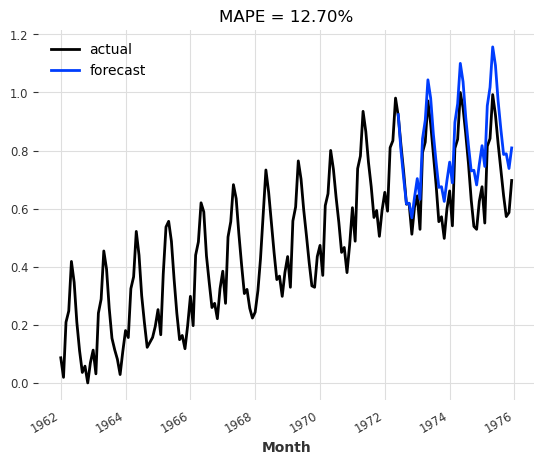

In [8]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
pred = model.predict(len(val))

series.plot(label="actual")
pred.plot(label="forecast")
plt.title("MAPE = {:.2f}%".format(mape(pred, val)))
plt.legend();